In [57]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, concatenate, Activation, Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG16, vgg16, ResNet50
import tensorflow.keras.backend as kb
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2
import scipy.io
from skimage import color

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.transform import resize

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib
print(matplotlib.__version__)

3.3.1


In [ ]:
pip install -q tensorflow-io

     |████████████████████████████████| 22.4MB 1.5MB/s 


In [ ]:
import skimage
print(skimage.__version__)

0.16.2


In [58]:
!pip install scikit-image==0.17.2

# New Section

In [ ]:
!pip install matplotlib==3.3.1

     |████████████████████████████████| 11.6MB 372kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [60]:
# Connect to TPU

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.31.111.250:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.31.111.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.111.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
lab_train = color.rgb2lab(X_train_orig)
lab_test = color.rgb2lab(X_test_orig)

In [62]:
yuv_train = color.rgb2yuv(X_train_orig)
yuv_test = color.rgb2yuv(X_test_orig)

In [66]:
X_train = np.expand_dims(yuv_train[:, :, :, 0], axis=-1)
X_test = np.expand_dims(yuv_test[:, :, :, 0], axis=-1)

y_train = yuv_train
y_test = yuv_test

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 1)
(50000, 32, 32, 3)
(10000, 32, 32, 1)
(10000, 32, 32, 3)


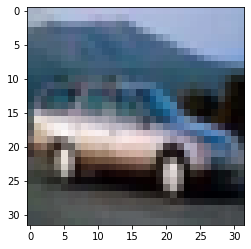

In [ ]:
# im = color.yuv2rgb(yuv_train[4])
# im = X_train[4].squeeze()

y_pred = y_train[4].squeeze()
y_pred = color.lab2rgb(y_pred)

# Y = y_pred[:,:,0]

# U = y_pred[:,:,1]
# V = y_pred[:,:,2]

# R = Y + 1.13983*V
# G = Y - 0.39465 * U - 0.58060 * V
# B = Y + 2.03211 * U

# y_pred = kb.stack((R,G,B), axis=-1)

plt.imshow(y_pred)

In [77]:
def model_fc(img_shape):
  input = Input(shape=img_shape, name='input')

  x = Conv2D(16, (3, 3), strides=(2,2), input_shape=img_shape, activation='relu', name='conv2d_1')(input)
  x = BatchNormalization(name='batchnorm_1')(x)

  x = Conv2D(16, (3, 3), activation='relu', name='conv2d_2')(x)
  x = BatchNormalization(name='batchnorm_2')(x)

  x = Conv2D(32, (3, 3), activation='relu', name='conv2d_3')(x)
  x = BatchNormalization(name='batchnorm_3')(x)

  x = Conv2D(32, (3, 3), activation='relu', name='conv2d_4')(x)
  x = BatchNormalization(name='batchnorm_4')(x)

  x = Flatten(name='flatten')(x)

  batch_size = kb.shape(input)[0]

  x = Dense((img_shape[0] * img_shape[0] * 2))(x)
  output = kb.reshape(x, (batch_size, img_shape[0], img_shape[0], 2))

  output = kb.concatenate((input, output), axis=-1)

  model = Model(
  inputs=(input),
  outputs=output,
  name="rgb_model")


  return model

In [78]:
model = model_fc((32,32,1))
print(model.summary())

Model: "rgb_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 16)   160         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 15, 15, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 13, 13, 16)   2320        batchnorm_1[0][0]                
__________________________________________________________________________________________

In [ ]:
def yuv_to_rgb(im_array):
    Y = im_array[:,:,:,0]
    U = im_array[:,:,:,1]
    V = im_array[:,:,:,2]

    R = (Y + 1.140*V) * 255
    G = (Y - 0.395 * U - 0.581 * V) * 255
    B = (Y + 2.032 * U) * 255

    # im_array = kb.concatenate((R,G,B), axis=-1)

    return R, G, B
    

def l2_rgb_loss(y_true, y_pred):
    """
    y_pred is the ab channels
    y_true is the rgb true image

    summary: converts y_pred to rgb and takes L2 loss
    """
    # # convert them both to numpy
    # y_true = y_true.numpy()
    # y_pred = y_pred.numpy()

    # # put the y_pred between 0 and 255 and get rgb version
    # y_pred = np.interp(y_pred, (y_pred.min(), y_pred.max()), (0, 255))
    # y_pred = color.yuv2rgb(y_pred)

    # R, G, B = yuv_to_rgb(y_pred)

    # diff = kb.square(y_true[:,:,:,0] - R)
    # diff += kb.square(y_true[:,:,:,1] - G)
    # diff += kb.square(y_true[:,:,:,2] - B)

    Y = y_pred[:,:,:,0]

    U = y_pred[:,:,:,1]
    V = y_pred[:,:,:,2]

    R = Y + 1.13983*V
    G = Y - 0.39465 * U - 0.58060 * V
    B = Y + 2.03211 * U

    y_pred = kb.stack((R,G,B), axis=-1)
    diff = kb.square(y_true - y_pred)

    return kb.mean(diff)

def l2_lab_to_rgb_loss(y_true, y_pred):
  print(tf.keras.backend.get_value(y_pred))

  diff = kb.square(y_true - y_pred)

  print(tf.keras.backend.get_value(diff))

  return kb.mean(diff)

In [ ]:
model = yuv_model_conv_2((32,32,1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=8e-3), loss='mse')


history = model.fit(X_train[:10], y_train[:10],
            epochs=1, verbose=2,
            validation_split=0.8, shuffle=True)


In [ ]:
def yuv_model_conv_2(img_shape):
  input = Input(shape=img_shape, name='input')

  x = Conv2D(32, (3, 3), padding='same', input_shape=img_shape, activation='relu', name='conv2d_1')(input)
  x = BatchNormalization(name='batchnorm_1')(x)

  x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_2')(x)
  x = BatchNormalization(name='batchnorm_2')(x)

  x = Conv2D(32, (3, 3), padding='same', name='conv2d_3')(x)
  x = BatchNormalization(name='batchnorm_3')(x)

  output = Conv2D(2, (3, 3), padding='same', name='conv2d_15')(x)

  output = kb.concatenate((input, output), axis=-1)

  model = Model(
    inputs=(input),
    outputs=output,
    name="rgb")

  return model


In [ ]:
def model_conv(img_shape):
    """ 
    img_shape: {tuple} shape of one image (height, width, num_channels)
    output: {model} a tensorflow model
    """

    input = Input(shape=img_shape, name='input')

    x = Conv2D(32, (3, 3), padding='same', input_shape=img_shape, activation='relu', name='conv2d_1')(input)
    x = BatchNormalization(name='batchnorm_1')(x)

    x = Conv2D(32, (3, 3), padding='same',activation='relu', name='conv2d_2')(x)
    x = BatchNormalization(name='batchnorm_2')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_3')(x)
    x = BatchNormalization(name='batchnorm_3')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_4')(x)
    x = BatchNormalization(name='batchnorm_4')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_5')(x)
    x = BatchNormalization(name='batchnorm_5')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_6')(x)
    x = BatchNormalization(name='batchnorm_6')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_7')(x)
    x = BatchNormalization(name='batchnorm_7')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_8')(x)
    x = BatchNormalization(name='batchnorm_8')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_10')(x)
    x = BatchNormalization(name='batchnorm_10')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_11')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_12')(x)
    x = BatchNormalization(name='batchnorm_12')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_13')(x)
    x = BatchNormalization(name='batchnorm_13')(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_14')(x)
    x = BatchNormalization(name='batchnorm_14')(x)

    output = Conv2D(2, (3, 3), padding='same', name='conv2d_15')(x)

    output = kb.concatenate((input, output), axis=-1)

    model = Model(
      inputs=(input),
      outputs=output,
      name="conv")
  
    return model

In [ ]:
model = yuv_model_conv((32,32,1))
print(model.summary())

Model: "rgb"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        batchnorm_1[0][0]                
________________________________________________________________________________________________

In [ ]:
def res_preprocess(image_array):
    """
    image_array: {array} array of shape (num_img, height, width, 1)
    values must not be normalized (i.e. on scale of 0-255)
    output: {array} image array of preprocessed images

    summary: preprocesses images in image_array for VGG
    """

    image_array = image_array[:,:,:, 0]
    image_array = np.stack((image_array,)*3, axis=-1)

    # preprocess for res
    # tf.keras.applications.resnet.preprocess_input(image_array, data_format=None)

    return image_array

In [ ]:
def res_cnn(img_shape):

    res = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)
    sliced_loaded_model = Sequential(res.layers[:13])
    new_input = sliced_loaded_model.input

    x = sliced_loaded_model.output

    x = Conv2D(128, (3, 3), padding='same', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_11')(x)
    x = Activation(tf.keras.activations.relu)(x)
    x = Conv2DTranspose(1, (1,1), strides=(2,2)) (x)

    x = Conv2D(128, (3, 3), padding='same', name='conv2d_22')(x)
    x = BatchNormalization(name='batchnorm_22')(x)
    x = Activation(tf.keras.activations.relu)(x)
    x = Conv2DTranspose(1, (1,1), strides=(2,2)) (x)

    x = Conv2D(64, (3, 3), padding='same', name='conv2d_33')(x)
    x = BatchNormalization(name='batchnorm_33')(x)
    x = Activation(tf.keras.activations.relu)(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv2d_44')(x)
    x = BatchNormalization(name='batchnorm_44')(x)
    x = Activation(tf.keras.activations.relu)(x)

    x = Conv2D(32, (3, 3), padding='same', name='conv2d_55')(x)
    x = BatchNormalization(name='batchnorm_55')(x)
    x = Activation(tf.keras.activations.relu)(x)

    x = Conv2D(32, (3, 3), padding='same', name='conv2d_66')(x)
    x = BatchNormalization(name='batchnorm_66')(x)
    x = Activation(tf.keras.activations.relu)(x)

    new_output = Conv2D(2, (3, 3),  padding='same', name='conv2d_77')(x)

    new_output = kb.concatenate((kb.expand_dims(new_input[:,:,:,0]), new_output), axis=-1)

    new_model = Model(
      inputs=(new_input),
      outputs=new_output,
      name="modified_res")
    return new_model

In [ ]:
model = vgg_cnn((32,32,3))
print(model.summary())

Model: "modified_res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 32, 32, 64)   36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   36928       block1_conv2[1][0]               
_______________________________________________________________________________________

In [ ]:
def vgg_cnn(img_shape):

    res = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
    sliced_loaded_model = Sequential(res.layers[:3])
    new_input = sliced_loaded_model.input

    for layer in sliced_loaded_model.layers:
        layer.trainable = False

    l2_reg = l2(1e-3)

    x = sliced_loaded_model.output

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_3')(x)
    x = BatchNormalization(name='batchnorm_3')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_4')(x)
    x = BatchNormalization(name='batchnorm_4')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_5')(x)
    x = BatchNormalization(name='batchnorm_5')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_6')(x)
    x = BatchNormalization(name='batchnorm_6')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_7')(x)
    x = BatchNormalization(name='batchnorm_7')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_8')(x)
    x = BatchNormalization(name='batchnorm_8')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_10')(x)
    x = BatchNormalization(name='batchnorm_10')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_11')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_12')(x)
    x = BatchNormalization(name='batchnorm_12')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_13')(x)
    x = BatchNormalization(name='batchnorm_13')(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_14')(x)
    x = BatchNormalization(name='batchnorm_14')(x)

    new_output = Conv2D(2, (3, 3), padding='same', name='conv2d_15')(x)

    new_output = kb.concatenate((kb.expand_dims(new_input[:,:,:,0]), new_output), axis=-1)

    new_model = Model(
      inputs=(new_input),
      outputs=new_output,
      name="modified_res")
    return new_model

In [ ]:
X_train_res = (res_preprocess(X_train) / 255) * 255
X_test_res = (res_preprocess(X_test) / 255) * 255

# X_train_res = np.concatenate((X_train_res, X_test_res), axis=0)

# y_train_res = (y_train / 255) * 255
# y_test_res = (y_test / 255) * 255

y_train_res = y_train
y_test_res = y_test

# y_train_res = np.concatenate((y_train_res, y_test_res), axis=0)

In [79]:
with tpu_strategy.scope():
  PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
  MODEL_TYPE = 'Regression/yuv_w_fc'

  model = model_fc((32,32,1))

  # stop training once validation loss stops improving
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


  # save the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PATH, f"{MODEL_TYPE}.h5"),
                                                  overwrite=True, save_weights_only=False, 
                                                  monitor='val_loss', mode='min', save_best_only=True)

  callbacks = [early, checkpoint]

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), loss='mse')


  history = model.fit(X_train, y_train,
              epochs=400, verbose=2,
              validation_split=0.2, batch_size=1024, shuffle=True, callbacks=[callbacks])

Epoch 1/400


40/40 - 6s - loss: 0.1696 - val_loss: 0.0040
Epoch 2/400
40/40 - 2s - loss: 0.0119 - val_loss: 0.0033
Epoch 3/400
40/40 - 2s - loss: 0.0069 - val_loss: 0.0032
Epoch 4/400
40/40 - 1s - loss: 0.0054 - val_loss: 0.0032
Epoch 5/400
40/40 - 1s - loss: 0.0047 - val_loss: 0.0032
Epoch 6/400
40/40 - 1s - loss: 0.0043 - val_loss: 0.0032
Epoch 7/400
40/40 - 2s - loss: 0.0040 - val_loss: 0.0032
Epoch 8/400
40/40 - 1s - loss: 0.0038 - val_loss: 0.0032
Epoch 9/400
40/40 - 2s - loss: 0.0036 - val_loss: 0.0031
Epoch 10/400
40/40 - 2s - loss: 0.0034 - val_loss: 0.0031
Epoch 11/400
40/40 - 1s - loss: 0.0033 - val_loss: 0.0031
Epoch 12/400
40/40 - 1s - loss: 0.0032 - val_loss: 0.0034
Epoch 13/400
40/40 - 1s - loss: 0.0032 - val_loss: 0.0033
Epoch 14/400
40/40 - 1s - loss: 0.0031 - val_loss: 0.0032
Epoch 15/400
40/40 - 2s - loss: 0.0031 - val_loss: 0.0035
Epoch 16/400
40/40 - 1s - loss: 0.0030 - val_loss: 0.0034
Epoch 17/400
40/40 - 1s - loss: 0.0031 - val_loss: 0.0033
Epoch 18/400
40/40 - 1s - loss: 0.0

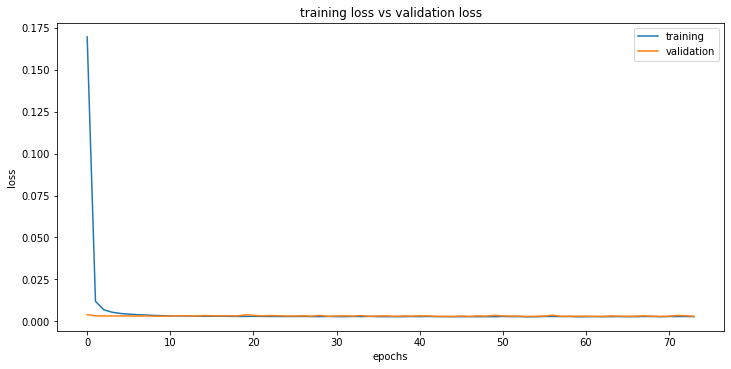

In [80]:
model_history(history, 10)

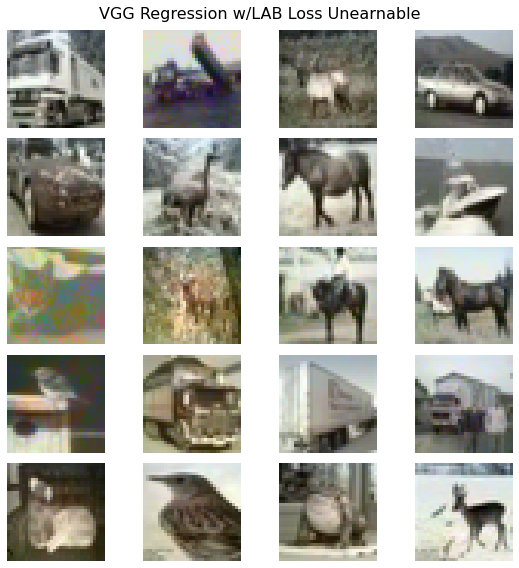

In [82]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
MODEL_TYPE = 'Regression/yuv_w_fc'

# model = tf.keras.models.load_model(os.path.join(PATH, f"{MODEL_TYPE}.h5"))
y_pred = model.predict(X_train[0:21])

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)

  # y_pred = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))

  # plt.imshow(X_test[i].squeeze(), cmap='gray')

  # # im_pred = y_pred[i].reshape(32, 32, 3)
  # im_pred = color.lab2rgb(y_pred[i])
  im_pred = color.yuv2rgb(y_pred[i])
  # im_pred = y_pred[i]

  im_pred = (im_pred - np.min(im_pred)) / (np.max(im_pred) - np.min(im_pred))
  plt.imshow(im_pred)


  # im_orig = y_train[i]
  # # # im_orig = color.yuv2rgb(im_orig)
  # plt.imshow(im_orig)


  plt.axis('off')

fig.tight_layout()  
plt.subplots_adjust(top=.94)
fig.suptitle('VGG Regression w/LAB Loss Unearnable', fontsize=16)
plt.show()

Evaluation

In [ ]:
lab_train = color.rgb2lab(X_train_orig)
lab_test = color.rgb2lab(X_test_orig)

yuv_train = color.rgb2yuv(X_train_orig)
yuv_test = color.rgb2yuv(X_test_orig)

In [ ]:
X_train = np.expand_dims(yuv_train[:, :, :, 0], axis=-1)
X_test = np.expand_dims(yuv_test[:, :, :, 0], axis=-1)

y_train = X_train_orig
y_test = X_test_orig

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 1)
(50000, 32, 32, 3)
(10000, 32, 32, 1)
(10000, 32, 32, 3)


In [ ]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
MODEL_TYPE = 'Regression/yuv_conv_rgb_loss'

# model = tf.keras.models.load_model(os.path.join(PATH, f"{MODEL_TYPE}.h5"), custom_objects={'l2_rgb_loss':l2_rgb_loss})

y_pred = model.predict(X_test[:10])
y_pred = color.yuv2rgb(y_pred)

# y_compare = color.yuv2rgb(y_test)
y_compare = y_test[:10]

In [ ]:
def AUC(im1, im2):
    diff = np.square(im1-im2)
    auc = np.zeros(256)
    for i in range(256):
        auc[i] += diff[diff<=i/512].size
    return auc, np.sum(auc)/(im1.size*256)

In [ ]:
auc, area = AUC(y_compare, y_pred)

print(area)

0.9829723358154296


In [ ]:
def __display_training_curves(training, validation, subplot):
    """
    summary: helper function for plotting the model history
    """
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('training loss vs validation loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['training', 'validation'])

def model_history(history, size=10):
    """
    history: {history} tensorflow history object
    size: {size} size of viewing window

    summary: plots the model history (training vs. validation loss)
    """
    plt.subplots(figsize=(size, size))
    plt.tight_layout()
    __display_training_curves(history.history['loss'], history.history['val_loss'], 211)
  
def evaluate_model(model, X_input, y_input, size=None):
    """
    summary: prints important performance indicators of the model and returns them.
            Also, if a figure size is specified, it plots the predicted vs actual
            values for the given inputs.

    input: takes in the model and X and y inputs to evaluate the model on.
    output: r2, mae, mse, mape
    """
    results = model.evaluate(X_input, y_input, verbose=0)

    y_pred = model.predict(X_input)

    r2 = r2_score(y_input, y_pred)
    mae = mean_absolute_error(y_input, y_pred)
    mse = mean_squared_error(y_input, y_pred)
    mape = results[2]

    if (size != None):
      plt.subplots(figsize=(size, size))
      visualize.__display_predictions(y_pred, y_input, 211)

    print(f"r^2: {r2}")
    print(f"mse: {mse}")
    print(f"mae: {mae}")
    print(f"mape: {mape}")

    return y_pred

In [ ]:
gamut = np.load('/content/drive/MyDrive/Junior Year/COS 429 - Team Project/pts_in_hull.npy')

NameError: ignored

In [ ]:
nn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(gamut)
# gamut_tensor = K.constant(gamut)

In [ ]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()
y_train_orig = color.rgb2lab(X_train_orig)

In [ ]:
quantized = get_qab1(y_train_orig)

In [ ]:
def get_qab1(img_ab, sigma=5, bins=313):
    # gets num_nb nearest neighbors
    batch, h, w, _ = img_ab.shape
    a = np.ravel(img_ab[:, :, :, 0])
    b = np.ravel(img_ab[:, :, :, 1])
    ab = np.vstack((a, b)).T  # now dim (H*W*2)
    distances, idx = nn.kneighbors(ab)

    # smoothen
    gaussian = np.exp(-distances**2 / (2*sigma**2))
    gaussian /= np.expand_dims(np.sum(gaussian, axis=1), axis=-1)
    flattened = np.dstack((idx, gaussian))
    output = np.reshape(flattened, (batch, h, w, sigma, 2))
    return output